In [14]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from collections import defaultdict
from sklearn.datasets import load_breast_cancer

# Problem 1
## Dataset Generation

Write a function to **generate a training set** of size $m$
- randomly generate a weight vector $w \in \mathbb{R}^{10}$, normalize length
- generate a training set $\{(x_i , y_i)\}$ of size m
  - $x_i$: random vector in $\mathbb{R}^{10}$ from $\textbf{N}(0, I)$
  - $y_i$: $\{0, +1\}$ with $P[y = +1] = \sigma(w \cdot x_i)$ and $P[y = 0] = 1 - \sigma(w \cdot x_i)$

In [15]:
def generate_data(m):
    # returns the true w as well as X, Y data
    
    # create a vector w of dimension 10 with each element being a standard normal random variable
    w = np.random.randn(10)
    # normalize the vector w
    w = w / np.linalg.norm(w)
    # create an m x 10 matrix X with each element being a standard normal random variable
    X = np.random.randn(m, 10)

    # create the output vector Y
    # to generate each Y[i], create using GenLabel function defined in the handout
    Y = np.zeros(m)
    for i in range(m):
        prob = 1 / (1 + np.exp(-np.dot(X[i], w)))
        Y[i] = 1 if np.random.rand() <= prob else 0
    return w, X, Y

## Algorithm 1: logistic regression

The goal is to learn $w$.  Algorithm 1 is logistic
  regression (you may use the built-in method LogisticRegression for this. Use max_iter=1000).

In [16]:
# apply logistic regression to learn w from data X, Y, using built in logistic regression library
def learn_w_logistic_regression(X, Y):
    model = LogisticRegression(solver='lbfgs', max_iter=1000, fit_intercept=False)
    model.fit(X, Y)
    w_learned = model.coef_[0] # 1xn vector
    return w_learned

def learn_w_gradient_descent(X, Y, learning_rate=0.01, max_iter=1000):
    m, n = X.shape
    w = np.zeros(n) # initialize w to be a zero vector of dimension n
    for _ in range(max_iter):
        # compute the predicted probabilities using the logistic function
        # compute z = sigmoid(X @ w) = 1 / (1 + exp(-X @ w))
        z = np.dot(X, w)
        y_pred = 1 / (1 + np.exp(-z))
        # loss for each point = 1/2 * (y_pred - Y)^2
        # gradient of loss with respect to w = 1/m * summation over i of ((y_pred-y) * y_pred * (1-y_pred) * X))
        # compute the gradient with respect to w
        gradient = (1/m) * np.dot(X.T, (y_pred - Y) * y_pred * (1 - y_pred))
        # update w using the gradient and learning rate
        w -= learning_rate * gradient
    return w

def learn_w_stochastic_gradient_descent(X, Y, learning_rate=0.01, max_iter=1000):
    m, n = X.shape
    w = np.zeros(n) # initialize w to be a zero vector of dimension n
    for _ in range(max_iter):
        i = np.random.randint(m) # randomly select an index i from 0 to m-1
        # compute the predicted probability for the i-th sample
        z = np.dot(X[i], w)
        y_pred = 1 / (1 + np.exp(-z))
        # loss for each point = 1/2 * (y_pred - Y)^2
        # gradient of loss with respect to w =  ((y_pred-y) * y_pred * (1-y_pred) * X))
        # compute the gradient with respect to w
        gradient = (y_pred - Y[i]) * y_pred * (1 - y_pred) * X[i]
        # update w using the gradient and learning rate
        w -= learning_rate * gradient
    return w

In [17]:
# capture norm diff for each algoritm against m in a dictionary, where key is m and value is avg of norm diff for 10 runs
from time import time


norm_diff_lg = defaultdict(float)
norm_diff_gd = defaultdict(float)
norm_diff_sgd = defaultdict(float)
time_taken_lg = defaultdict(float)
time_taken_gd = defaultdict(float)
time_taken_sgd = defaultdict(float)
total_iterations = 10
for m in [50, 100, 150, 200, 250]:
    norm_diff_total_lg, norm_diff_total_gd, norm_diff_total_sgd = 0, 0, 0
    for _ in range(total_iterations):
        # Generate data
        w_true, X, Y = generate_data(m)

        # logistic regression to learn w from data X, Y
        start_time = time()
        w_leanered = learn_w_logistic_regression(X, Y)
        end_time = time()
        # capture time taken for logistic regression in seconds, round to 4 decimal places
        time_taken_lg[m] += round(end_time - start_time, 4)
        # print("True w:", w_true)
        # print("Learned w:", w_leanered)
        # compute norm of difference between true w and learned w
        norm_diff = np.linalg.norm(w_true - w_leanered)
        norm_diff_total_lg += norm_diff

        # gradient descent to learn w from data X, Y
        start_time = time()
        w_leanered = learn_w_gradient_descent(X, Y)
        end_time = time()
        # capture time taken for gradient descent in seconds, round to 4 decimal places
        time_taken_gd[m] += round(end_time - start_time, 4)
        # print("True w:", w_true)
        # print("Learned w:", w_leanered)
        # compute norm of difference between true w and learned w
        norm_diff = np.linalg.norm(w_true - w_leanered)
        norm_diff_total_gd += norm_diff

        # stochastic gradient descent to learn w from data X, Y
        start_time = time()
        w_leanered = learn_w_stochastic_gradient_descent(X, Y)
        end_time = time()
        # capture time taken for stochastic gradient descent in seconds, round to 4 decimal places
        time_taken_sgd[m] += round(end_time - start_time, 4)
        # print("True w:", w_true)
        # print("Learned w:", w_leanered)
        # compute norm of difference between true w and learned w
        norm_diff = np.linalg.norm(w_true - w_leanered)
        norm_diff_total_sgd += norm_diff

    # compute average of norm_diff over 10 runs
    norm_diff_lg[m] = norm_diff_total_lg / total_iterations
    norm_diff_gd[m] = norm_diff_total_gd / total_iterations
    norm_diff_sgd[m] = norm_diff_total_sgd / total_iterations

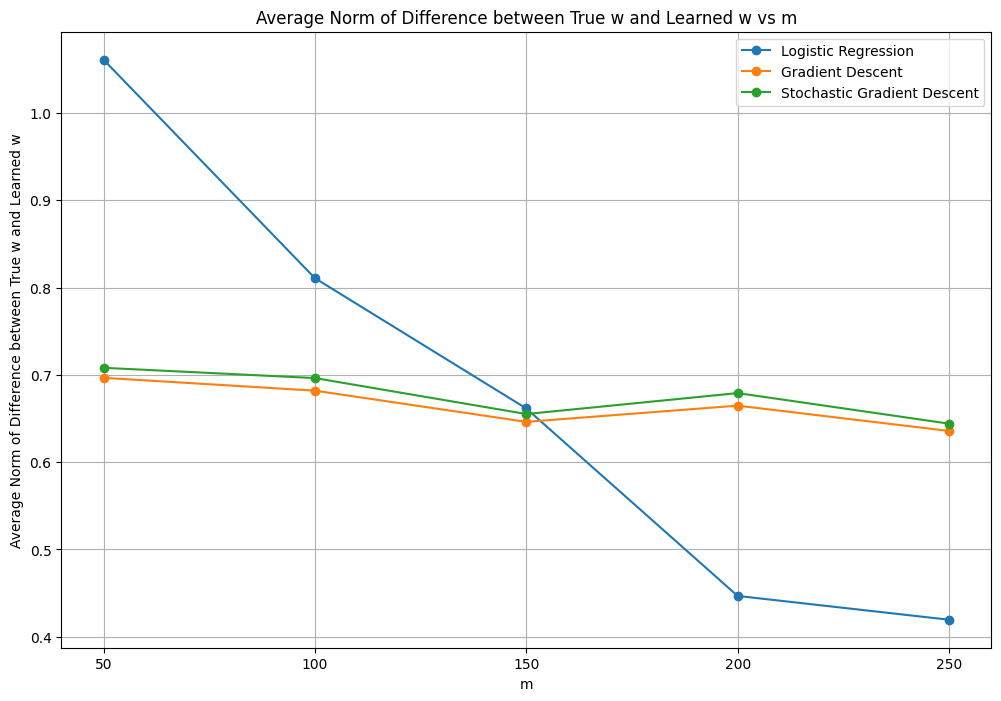

In [18]:
# plot the norm_diff for each algorithm against m in a single plot
FIGSIZE = (12,8)
plt.figure(figsize=FIGSIZE)
plt.plot(list(norm_diff_lg.keys()), list(norm_diff_lg.values()), label='Logistic Regression', marker='o')
plt.plot(list(norm_diff_gd.keys()), list(norm_diff_gd.values()), label='Gradient Descent', marker='o')
plt.plot(list(norm_diff_sgd.keys()), list(norm_diff_sgd.values()), label='Stochastic Gradient Descent', marker='o')
plt.xlabel('m')
plt.ylabel('Average Norm of Difference between True w and Learned w')
plt.title('Average Norm of Difference between True w and Learned w vs m')
plt.legend()
plt.xticks([50, 100, 150, 200, 250])
plt.grid()
plt.show()

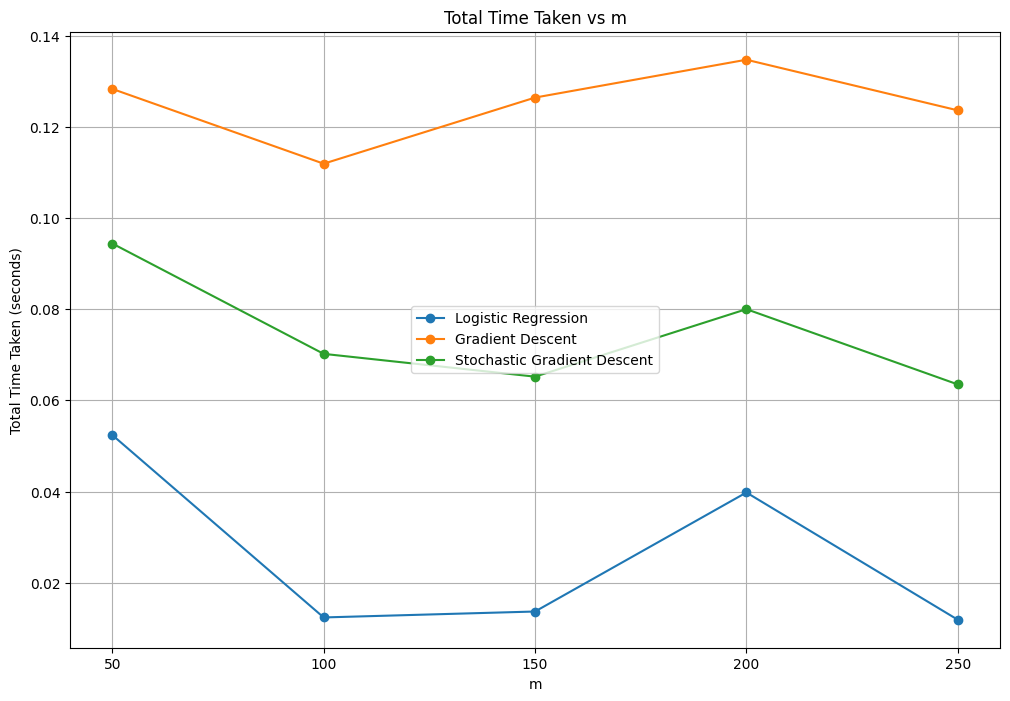

In [19]:
# plot the time taken for each algorithm against m in a single plot
plt.figure(figsize=FIGSIZE)
plt.plot(list(time_taken_lg.keys()), list(time_taken_lg.values()), label='Logistic Regression', marker='o')
plt.plot(list(time_taken_gd.keys()), list(time_taken_gd.values()), label='Gradient Descent', marker='o')
plt.plot(list(time_taken_sgd.keys()), list(time_taken_sgd.values()), label='Stochastic Gradient Descent', marker='o')
plt.xlabel('m')
plt.ylabel('Total Time Taken (seconds)')
plt.title('Total Time Taken vs m')
plt.legend()
plt.xticks([50, 100, 150, 200, 250])
plt.grid()
plt.show()

## Algorithm 2: gradient descent with square loss

Define square loss as
$$L_i(w^{(t)}) = \frac{1}{2} \left( \sigma(w^{(t)} \cdot x) - y_i \right)^2$$

  Algorithm 2 is
  gradient descent with respect to square loss (code this
  up yourself -- run for 1000 iterations, use step size eta = 0.01).

## Algorithm 3: stochastic gradient descent with square loss
Similar to gradient descent, except we use the gradient at a single random training point every iteration.

In [20]:
# All the computation and plotting is done in the above code.

## Evaluation

Measure error $\|w - \hat{w}\|_2$ for each method at different sample size. For any
  fixed value of $m$, choose many different $w$'s and average the
  values $\|w - 
  \hat{w}\|_2$ for Algorithms 1, 2 and 3.  Plot the results
  for for each algorithm as you make $m$ large (use $m=50, 100, 150, 200, 250$).
  Also record, for each algorithm, the time taken to run the overall experiment.

In [21]:
# All the computation and plotting is done in the above code.

# Problem 2

In [22]:
from sklearn import datasets

In [23]:
cancer = datasets.load_breast_cancer()

For each depth in $1, \dots, 5$, instantiate an AdaBoost classifier with the base learner set to be a decision tree of that depth (set `n_estimators=10` and `learning_rate=1`), and then record the 10-fold cross-validated error on the entire breast cancer data set. Plot the resulting curve of accuracy against base classifier depth. Use $101$ as your random state for both the base learner as well as the AdaBoost classifier every time.

In [24]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
RANDOM_STATE = 101
cv_accuracy_dt_clf = defaultdict(float)
cv_accuracy_ada_clf = defaultdict(float)
for depth in [1, 2, 3, 4, 5]:
    # create a decision tree classifier with max depth depth
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=RANDOM_STATE)
    dt_clf.fit(X, y)
    cv_scores = cross_val_score(dt_clf, X, y, cv=10)
    print(f"depth: {depth}, DT classifier 10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    cv_accuracy_dt_clf[depth] = np.mean(cv_scores)
    
    # create an AdaBoost classifier with the decision tree as the base estimator, n_estimators=10, learning_rate=1.0, and random_state=RANDOM_STATE
    ada_clf = AdaBoostClassifier(dt_clf, n_estimators=10, random_state=RANDOM_STATE, learning_rate=1.0)
    ada_clf.fit(X, y)
    cv_scores = cross_val_score(ada_clf, X, y, cv=10)
    print(f"Depth: {depth}, AdaBoost Classifier 10-Fold CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")
    cv_accuracy_ada_clf[depth] = np.mean(cv_scores)

depth: 1, DT classifier 10-Fold CV Accuracy: 0.8893 ± 0.0259
Depth: 1, AdaBoost Classifier 10-Fold CV Accuracy: 0.9508 ± 0.0246
depth: 2, DT classifier 10-Fold CV Accuracy: 0.9192 ± 0.0262
Depth: 2, AdaBoost Classifier 10-Fold CV Accuracy: 0.9508 ± 0.0188
depth: 3, DT classifier 10-Fold CV Accuracy: 0.9104 ± 0.0418
Depth: 3, AdaBoost Classifier 10-Fold CV Accuracy: 0.9648 ± 0.0235
depth: 4, DT classifier 10-Fold CV Accuracy: 0.9139 ± 0.0307
Depth: 4, AdaBoost Classifier 10-Fold CV Accuracy: 0.9579 ± 0.0274
depth: 5, DT classifier 10-Fold CV Accuracy: 0.9140 ± 0.0395
Depth: 5, AdaBoost Classifier 10-Fold CV Accuracy: 0.9666 ± 0.0241


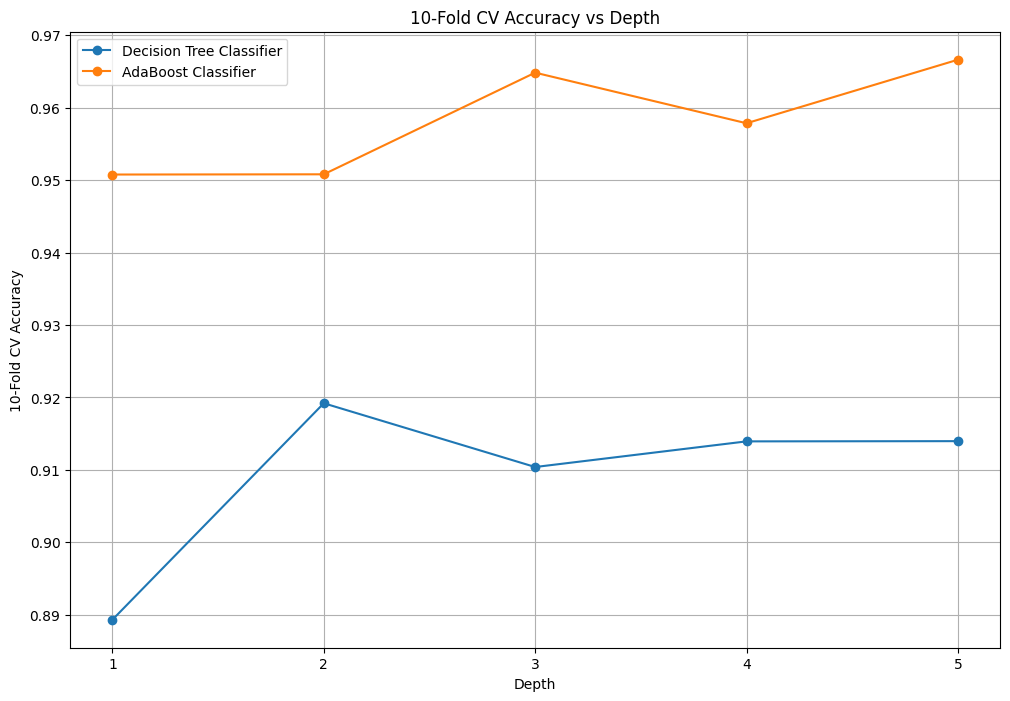

In [25]:
# plot the cv_accuracy for each algorithm against depth in a single plot
plt.figure(figsize=FIGSIZE)
plt.plot(list(cv_accuracy_dt_clf.keys()), list(cv_accuracy_dt_clf.values()), label='Decision Tree Classifier', marker='o')
plt.plot(list(cv_accuracy_ada_clf.keys()), list(cv_accuracy_ada_clf.values()), label='AdaBoost Classifier', marker='o')
plt.xlabel('Depth')
plt.ylabel('10-Fold CV Accuracy')
plt.title('10-Fold CV Accuracy vs Depth')
plt.legend()
plt.xticks([1, 2, 3, 4, 5])
plt.grid()
plt.show()